# Objective: To build a model to understand the factors on which the demand for shared bikes depends.

In [1]:
#Importing liabraries:
import numpy as np
import pandas as pd
import datetime 
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing ML liabraries
from sklearn.model_selection import train_test_split #For splitting into train-test set
from sklearn.preprocessing import MinMaxScaler       #For scaling
from sklearn.feature_selection import RFE            #For automatic feature elimination
from sklearn.linear_model import LinearRegression    #For linear regression model building 
import statsmodels.api as sm                         #For Linear reg model with detailed stats 
from statsmodels.stats.outliers_influence import variance_inflation_factor  #For VIF calculation

In [3]:
def vif_values(dataframe):         # Function to return vif values of independent variables
    vif = pd.DataFrame()
    X = dataframe
    vif['features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return vif

In [4]:
def box(y_var,x_var=None):     #For box plot
    sns.boxplot(data = df, y = y_var,x=x_var)
    if x_var==None:
        plt.title(f'{y_var} distribution')
    else:
        plt.title(f'{x_var} vs {y_var}')

In [5]:
def plot(attr):                #For box and barplot adjecently
    plt.figure(figsize=[15,4])
    plt.subplot(1,2,1)
    sns.boxplot(data = df, y = 'cnt', x = attr)
    plt.title(f'{attr} vs demand')
    plt.subplot(1,2,2)
    sns.barplot(data = df, y = 'cnt', x = attr, hue='yr')
    plt.title(f'{attr} vs demand for year 2018 and 2019')

#### Data Sourcing:
* Dataset contains historical data of daily business of a company BoomBikes which is a US bike-sharing provider. It has records of years 2018 and 2019. 

In [6]:

df = pd.read_csv(r'C:\Users\ADMIN\Downloads\day.csv')   
df.shape

(730, 16)

In [7]:
df.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349


## <font color=orange>Decisions for modelling approach: </font>
* Since we have past data with labels, we will use `SUPERVISED LEARNING METHOD`.
* As per the objective, our `target variable is 'cnt'` since it represents demand i.e. count of total    rental bikes.
* Since target variable is continous variable we will use `REGRESSION` supervised learning method.

#### Data cleaning:

In [8]:
# Removing 'instant' attribute since it is not useful for model building as it just represents an index.
df.drop('instant',axis=1,inplace=True)
df.info()                               # Checking for missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 85.7+ KB


In [9]:
''' There are no missing values in our dataset. '''
df = df.drop_duplicates()                #Removing duplicate rows if any.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB


#### Formatting data for readability:
* For improving explainibility of the model,we will map the values of multi-level categorical variables to appropriate meaningful labels.

In [11]:
df['season'] = df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df['mnth'] = df.mnth.apply(lambda x: calendar.month_abbr[x])
df['weathersit'] = df.weathersit.map({1:'Clear', 2:'Mist', 3:'Light rain/snow', 4:'Heavy rain/snow'})

In [12]:
df.pivot_table(columns='weekday',values='workingday',aggfunc='sum')   #varifying mapping for weekdays

weekday,0,1,2,3,4,5,6
workingday,0,90,103,102,102,102,0


In [13]:
# Since weekday 0 and 6 corresponds to total 0 working days they must correspond to sun and sat.
df['weekday'] = df.weekday.map({0: 'Sun',1: 'Mon', 2: 'Teu', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})

#### EDA:
* Visualizing data for basic understanding of dataset

In [14]:
num_attributes = ['temp','atemp','hum','windspeed','casual','registered','cnt']
df[num_attributes].describe()           #Stats summary

,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


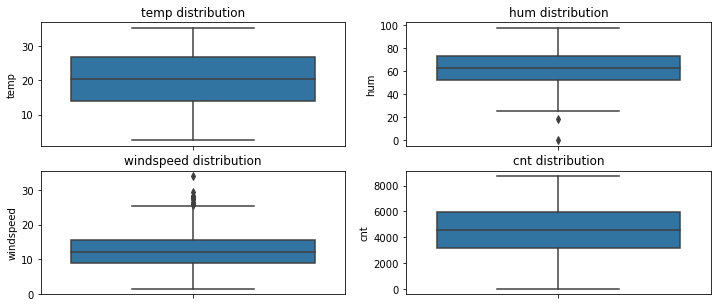

In [15]:
plt.figure(figsize=[12,5])
plt.subplot(2,2,1)
box('temp')
plt.subplot(2,2,2)
box('hum')
plt.subplot(2,2,3)
box('windspeed')
plt.subplot(2,2,4)
box('cnt')
plt.show()

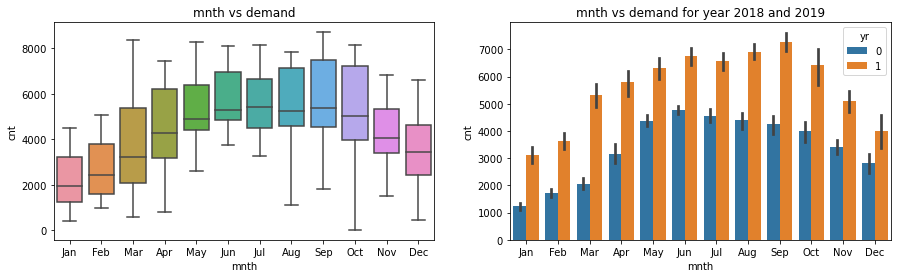

In [16]:
plot('mnth') 

Median value of count of shared bikes is highest for month of september and july.

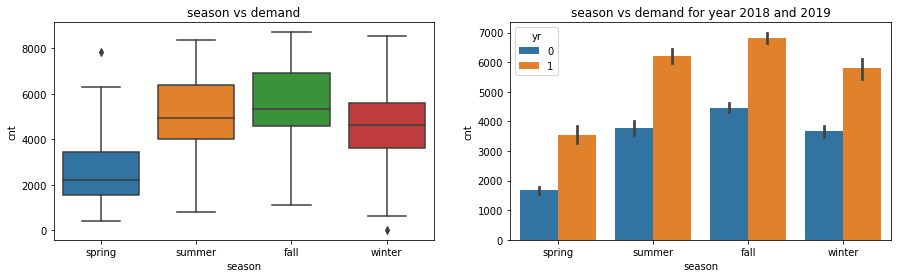

In [17]:
plot('season')

Median value of count of shared bikes is highest in fall season and least in spring.

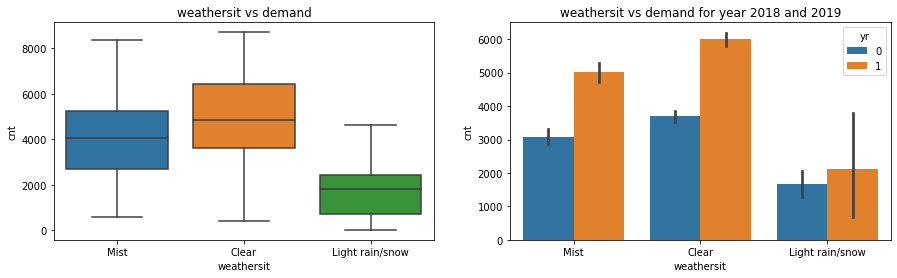

In [18]:
plot('weathersit')

Median value of count of shared bikes is highest in clear climate and least when there is light rain/snow.

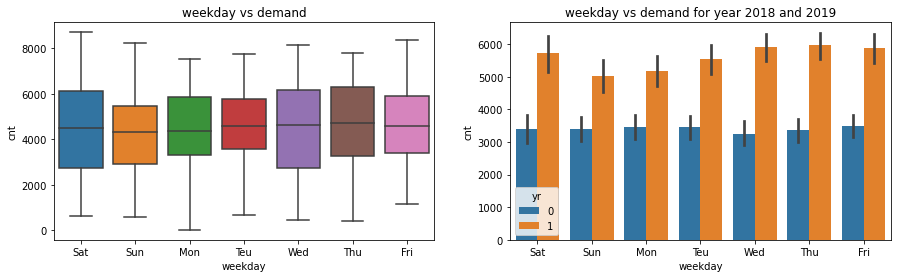

In [19]:
plot('weekday')

No trend observed w.r.t weekdays for demand. 

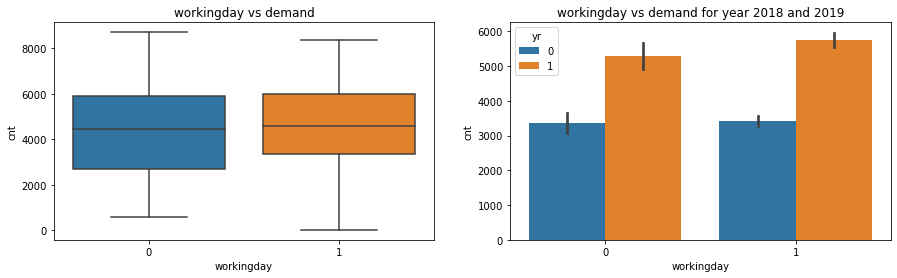

In [20]:
plot('workingday')

No trend observed w.r.t workingday for demand. 

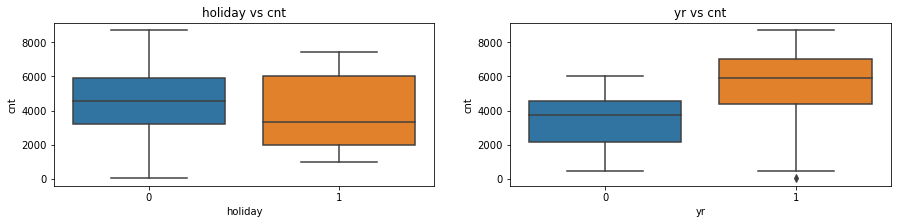

In [21]:
plt.figure(figsize=[15,3])
plt.subplot(1,2,1)
box(y_var = 'cnt', x_var = 'holiday')
plt.subplot(1,2,2)
box(y_var = 'cnt', x_var='yr')

* No trend observed w.r.t holiday for demand.
* Demand grew from year 2018 to 2019.

#### Deriving new variables:
* we will derive date from 'dteday' 

In [22]:
df['dteday'] = pd.to_datetime(df['dteday'],format='%d-%m-%Y')  # Converting 'dteday' to date time object
df['date'] = df['dteday'].apply(lambda x:x.day) # Extracting date
df.drop('dteday',axis=1,inplace=True) #Droping column as it will not be useful for further modelling.

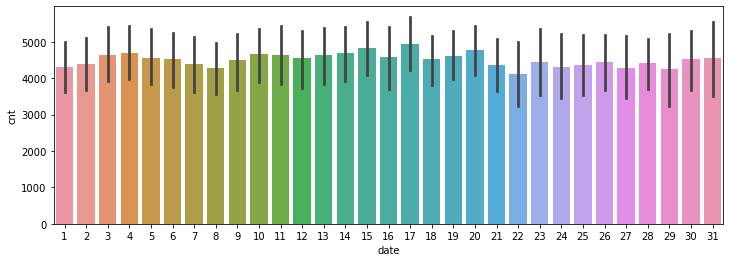

In [23]:
plt.figure(figsize=[12,4])
sns.barplot(data=df,y='cnt',x='date')
plt.show()

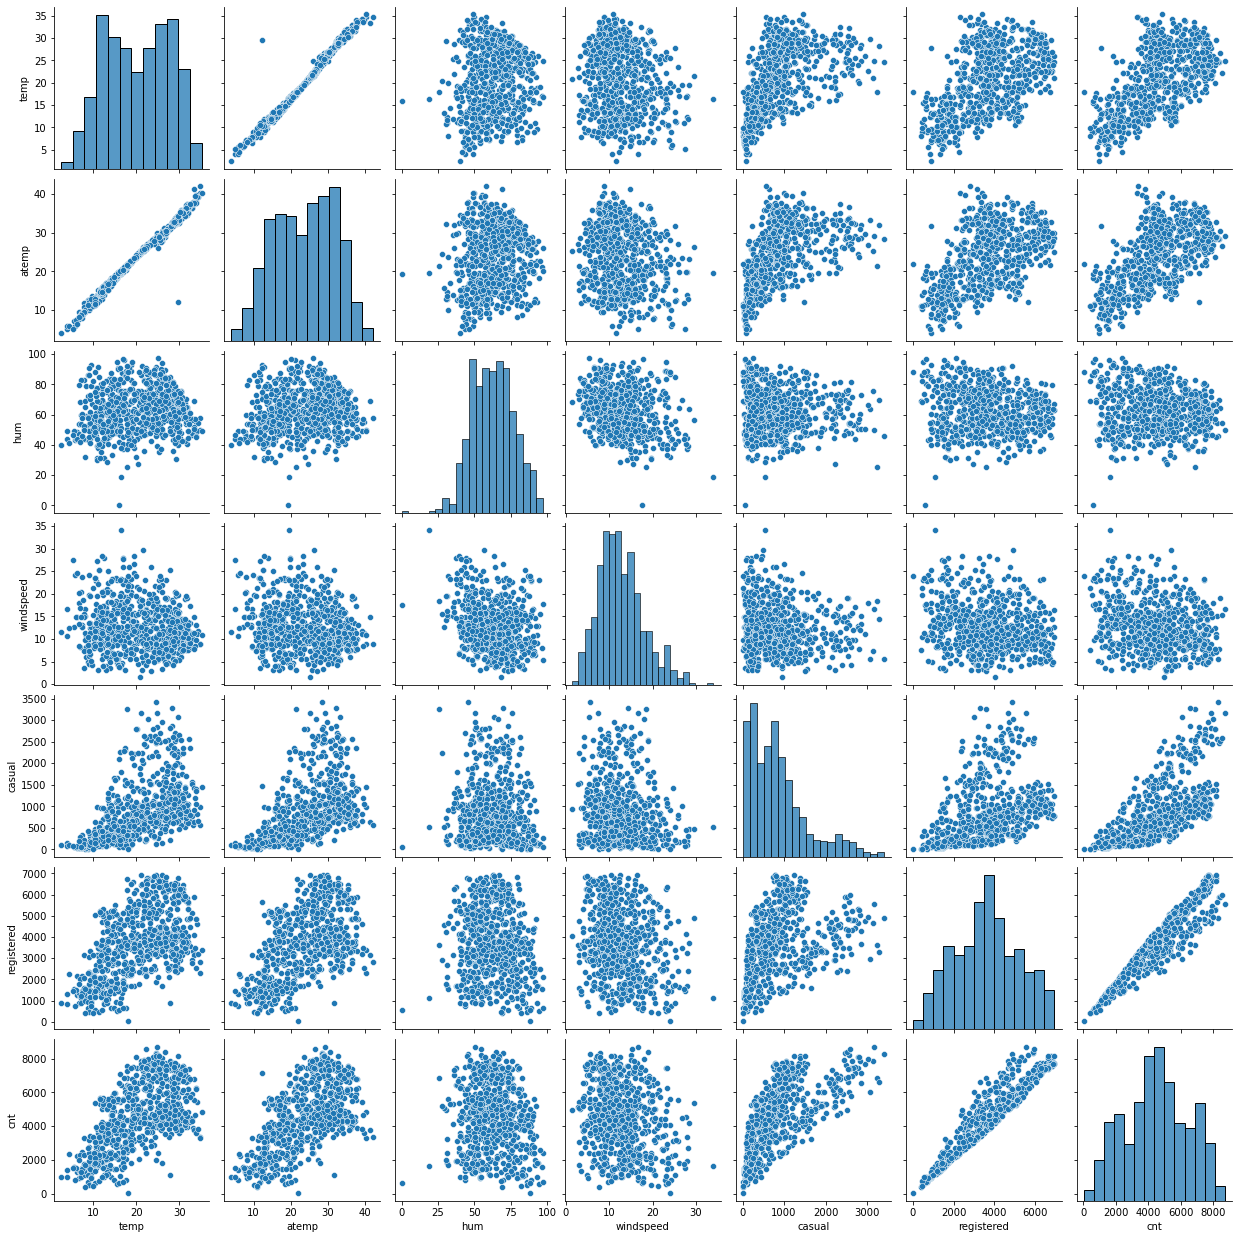

In [24]:
sns.pairplot(data=df, vars = num_attributes)
plt.show()

In [25]:
correl=df[num_attributes].corr()
correl.style.background_gradient(cmap='coolwarm').set_precision(2)

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1.00,0.99,0.13,-0.16,0.54,0.54,0.63
atemp,0.99,1.00,0.14,-0.18,0.54,0.54,0.63
hum,0.13,0.14,1.00,-0.25,-0.08,-0.09,-0.10
windspeed,-0.16,-0.18,-0.25,1.00,-0.17,-0.22,-0.24
casual,0.54,0.54,-0.08,-0.17,1.00,0.39,0.67
registered,0.54,0.54,-0.09,-0.22,0.39,1.00,0.95
cnt,0.63,0.63,-0.10,-0.24,0.67,0.95,1.00


## <font color=orange>Assumptions of Multiple Linear Regression: </font>
1. There is a linear relation between target variable (y) and predictors (X).
2. Error terms are independent, normally distributed with zero mean and have constant variance.
3. Predictor variables should not have Multicollinearity.

#### From above pairplot and correlation heatmap we can conclude the following :  
* There seem to be a linear relationship between target variable 'cnt' and predictor 'temp'. So we can try to fit a `Multiple Linear Regression model`.
* There is `very high correlation between 'temp' and 'atemp'`. Which does not satisfy multicollinearity assumption. Hence we can either drop 'atemp' variable here or let RFE take care of it later. 
* Target variable can fully be explained using sum of predictors 'casual' and 'registered'. Thus `to avoid data leakage we will be dropping 'casual' and 'registered'`. We will not have present data of 'registered' and 'casual' anyway to determine the current demand, this further justifies the dropping.

In [26]:
df.drop(['registered','casual'],axis=1,inplace=True)

### <font color=orange>Data preparation </font>

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
 12  date        730 non-null    int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 99.8+ KB


In [28]:
# Creating dummy variables:
dummy_list = ['season','mnth','weekday','weathersit']
dummies = pd.get_dummies(df[dummy_list],drop_first=True) #Dropping one of the levels since it's redundant.

In [29]:
df.drop(dummy_list,axis=1,inplace=True)  # Droping original columns after extracting dummy variables
df = pd.concat([df,dummies],axis = 1) # Concating dummy variables to original dataframe
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,date,season_spring,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Teu,weekday_Thu,weekday_Wed,weathersit_Light rain/snow,weathersit_Mist
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,1,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,2,1,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,3,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,4,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,5,1,...,0,0,0,0,0,0,0,1,0,0


#### <font color=orange>Checking correlation </font>

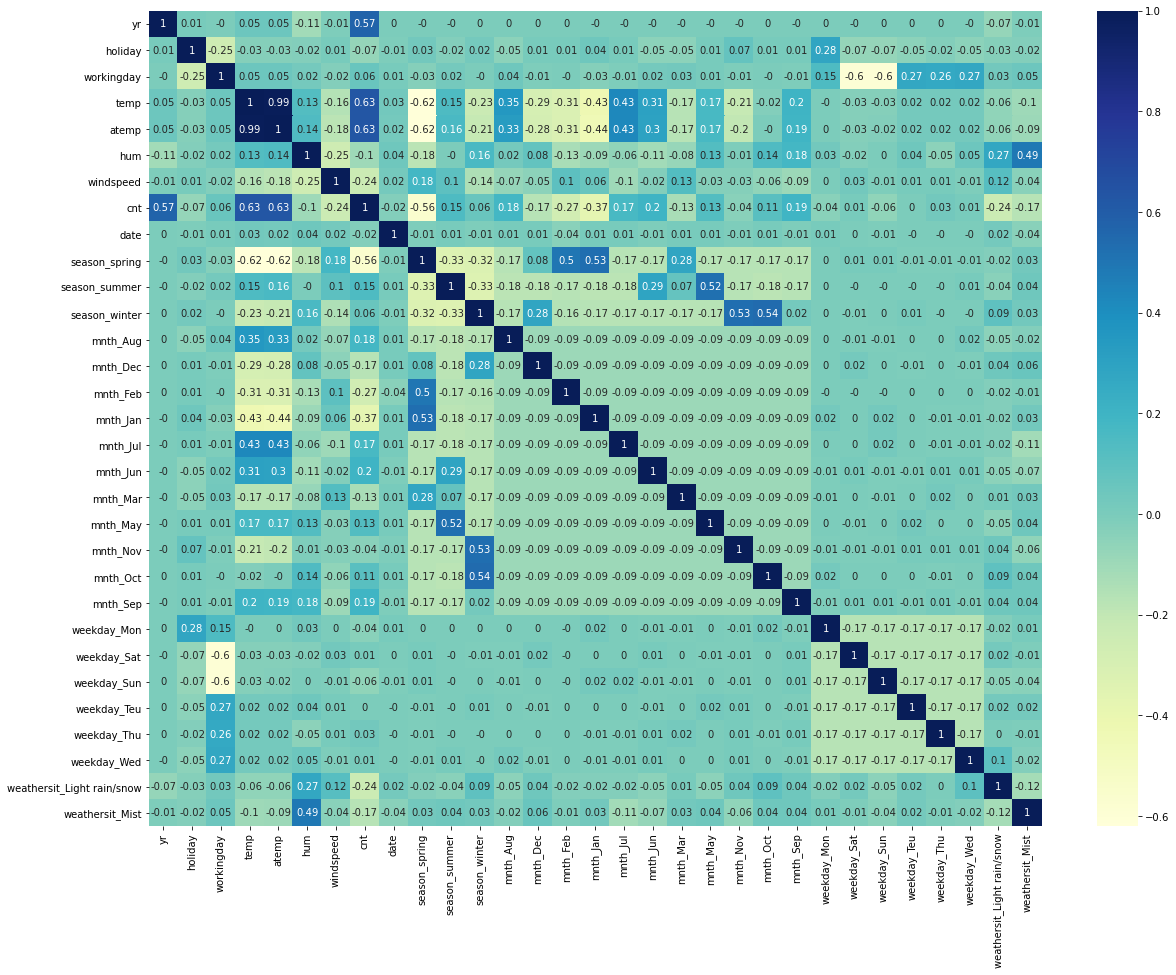

In [30]:
plt.figure(figsize=[20,15])
sns.heatmap(round(df.corr(),2),annot=True,cmap="YlGnBu")
plt.show()

temp and atemp has high correlation and thus can be dropped here itself or let rfe take care of it.

###  <font color=orange>Splitting the Data into Training and Testing Sets </font>

In [31]:
# Spltting data such that training and test data corresponds to 70% and 30% of original dataset resp.
# We specify this so that the train and test data set always have the same rows.
np.random.seed(0)  #To initialize a pseudorandom number generator.
df_train,df_test = train_test_split(df,test_size=0.3,random_state=100) 

In [32]:
df_train.shape

(511, 31)

In [33]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,date,season_spring,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Teu,weekday_Thu,weekday_Wed,weathersit_Light rain/snow,weathersit_Mist
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,...,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.508806,0.025440,0.677104,20.106483,23.499390,63.109443,12.833686,4491.303327,15.592955,0.242661,...,0.086106,0.080235,0.150685,0.154599,0.142857,0.133072,0.133072,0.158513,0.029354,0.344423
std,0.500412,0.157613,0.468042,7.424445,8.083052,14.142965,5.286912,1953.413860,8.903110,0.429112,...,0.280795,0.271923,0.358092,0.361876,0.350270,0.339986,0.339986,0.365579,0.168963,0.475645
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,2.834381,22.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,13.649576,16.634475,52.291650,9.041918,3123.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,20.260847,24.115200,63.416700,12.124789,4539.000000,16.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,26.615847,30.177700,73.208350,15.750595,6008.500000,23.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.041700,34.000021,8714.000000,31.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
# Humidity has minimum value equals to 0 which is impossible.
hum_med = df_train.hum.median()
df_train['hum']= np.where(df_train['hum'] == 0, hum_med,df_train['hum']) #Replacing with median

###  <font color=orange>Data scaling </font>
* scaling continous (and non-binary level) predictors using `MinMax scaling`.

In [35]:
scaler = MinMaxScaler()   # Creating a scaler object using MinMaxScaler()

In [36]:
num_vars = ['temp','hum','windspeed','date','cnt']
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])  #'transform' and 'Fit' the train set
df_train.head(2)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,date,season_spring,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Teu,weekday_Thu,weekday_Wed,weathersit_Light rain/snow,weathersit_Mist
653,1,0,1,0.509887,23.0423,0.473375,0.300794,0.864243,0.5,0,...,1,0,0,0,0,1,0,0,0,0
576,1,0,1,0.815169,33.1448,0.659744,0.264686,0.827658,1.0,0,...,0,0,0,0,0,1,0,0,0,0


### <font color=orange>Dividing into X and Y sets for the model building </font>

In [37]:
y_train = df_train.pop('cnt')  #extracting target variable from train set
X_train = df_train             #extracting predictors from train set

### <font color=orange>Model building </font>
* Since there are large number of predictors we will be using Recursive Feature Elimination method to optimally select the predictors
* we will be using the LinearRegression function from SciKit Learn for its compatibility with RFE.

In [38]:
lm = LinearRegression()           #Creating lm object using LinearRegression() 
lm.fit(X_train,y_train)           #fit the model on training data

rfe = RFE(lm,14)                 # Running RFE with the output number of the variable equal to 14.
rfe = rfe.fit(X_train,y_train)

In [39]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))  #Gives feature elimination ranking

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 17),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('date', False, 15),
 ('season_spring', True, 1),
 ('season_summer', False, 2),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 8),
 ('mnth_Dec', False, 5),
 ('mnth_Feb', False, 6),
 ('mnth_Jan', False, 3),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 11),
 ('mnth_Mar', False, 10),
 ('mnth_May', False, 7),
 ('mnth_Nov', False, 4),
 ('mnth_Oct', False, 14),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', False, 13),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', True, 1),
 ('weekday_Teu', False, 9),
 ('weekday_Thu', False, 12),
 ('weekday_Wed', False, 16),
 ('weathersit_Light rain/snow', True, 1),
 ('weathersit_Mist', True, 1)]

In [40]:
col = X_train.columns[rfe.support_]   ## Features selected by rfe
col 

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_winter', 'mnth_Jul', 'mnth_Sep', 'weekday_Sat',
       'weekday_Sun', 'weathersit_Light rain/snow', 'weathersit_Mist'],
      dtype='object')

In [41]:
X_train.columns[~rfe.support_]       # Features eliminated by rfe

Index(['atemp', 'date', 'season_summer', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb',
       'mnth_Jan', 'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct',
       'weekday_Mon', 'weekday_Teu', 'weekday_Thu', 'weekday_Wed'],
      dtype='object')

## <font color=orange>Building model using statsmodel, for the detailed statistics </font>

In [42]:
X_train_rfe = X_train[col]  # Creating X_train dataframe with RFE selected variables
X_train_rfe = sm.add_constant(X_train_rfe)  # Adding a constant variable 

#### <font color=orange>Model 1: </font>

In [43]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [44]:
print(lm.summary())  #Summary of built model

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.1
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          3.94e-190
Time:                        21:18:50   Log-Likelihood:                 511.14
No. Observations:                 511   AIC:                            -994.3
Df Residuals:                     497   BIC:                            -935.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [45]:
'''since p-value for holiday (0.518) is greater than the significant level of 0.05, we fail to reject the 
   null hypothesis. Null hupothesis is slope coefficient of holiday is insignificant. As we fail to 
   reject the null hupothesis, we will drop 'holiday' since it is insignificant'''

col = col.drop(["holiday"]) # Dropping holiday from selected predictors
X_train_new = X_train[col]  # Creating X_train dataframe with newly selected variables.

#### <font color=orange>Model 2: </font>

In [46]:
X_train_lm = sm.add_constant(X_train_new)   # Adding a constant term 
lm= sm.OLS(y_train,X_train_lm).fit()        # Running the linear model

In [47]:
print(lm.summary())       # Summary of newly built model

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.1
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          3.94e-190
Time:                        21:18:51   Log-Likelihood:                 511.14
No. Observations:                 511   AIC:                            -994.3
Df Residuals:                     497   BIC:                            -935.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [48]:
# Since all p-values are less than significance level(.05), their beta coefficients are significant.
# Hence we will further check for multicollinearity for feature selection.

### <font color=orange>Checking multicolinearity with VIF </font>
* To check multicollinearity among predictors we will use vif parameter.

In [49]:
vif_values(X_train_new)   

,features,VIF
3,hum,20.10
2,temp,16.58
1,workingday,15.14
4,windspeed,4.63
9,weekday_Sat,4.15
10,weekday_Sun,4.04
5,season_spring,2.70
12,weathersit_Mist,2.45
0,yr,2.09
6,season_winter,2.08


In [50]:
'''since hum has high VIF i.e. greater than 10, it is highly correlated with other predictors and 
   thus can be explained by other independent variables. Hence droping it from the model'''
col = col.drop(["hum"]) # Dropping hum from selected predictors
X_train_new = X_train[col]  # Creating X_train dataframe with newly selected variables.

#### <font color=orange>Model 3: </font>

In [51]:
X_train_lm = sm.add_constant(X_train_new)   # Adding a constant term
lm= sm.OLS(y_train,X_train_lm).fit()        # Running the linear model

In [52]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     214.8
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          4.75e-188
Time:                        21:18:51   Log-Likelihood:                 503.40
No. Observations:                 511   AIC:                            -980.8
Df Residuals:                     498   BIC:                            -925.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [53]:
vif_values(X_train_new)

,features,VIF
1,workingday,13.15
2,temp,12.40
3,windspeed,4.48
8,weekday_Sat,3.76
9,weekday_Sun,3.53
4,season_spring,2.44
0,yr,2.07
5,season_winter,1.78
11,weathersit_Mist,1.58
6,mnth_Jul,1.37


In [54]:
'''since workingday has high VIF i.e. greater than 10, it is highly correlated with other predictors.
   Hence droping it from the model'''
col = col.drop(["workingday"]) # Dropping workingday from selected predictors
X_train_new = X_train[col]  # Creating X_train dataframe with newly selected variables.

#### <font color=orange>Model 4: </font>

In [55]:
X_train_lm = sm.add_constant(X_train_new)   # Adding a constant term
lm= sm.OLS(y_train,X_train_lm).fit()        # Running the linear model

In [56]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     226.1
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          7.47e-186
Time:                        21:18:51   Log-Likelihood:                 495.37
No. Observations:                 511   AIC:                            -966.7
Df Residuals:                     499   BIC:                            -915.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [57]:
vif_values(X_train_new)

,features,VIF
1,temp,4.73
2,windspeed,4.04
0,yr,2.06
3,season_spring,1.66
10,weathersit_Mist,1.51
4,season_winter,1.41
5,mnth_Jul,1.35
7,weekday_Sat,1.22
6,mnth_Sep,1.20
8,weekday_Sun,1.20


In [58]:
#Since p-value for weekday_Sat (0.196) > significance level(0.05), its beta coefficient is insignificant.
col = col.drop(["weekday_Sat"]) # Dropping weekday_Sat from selected predictors
X_train_new = X_train[col]  # Creating X_train dataframe with newly selected variables.

#### <font color=orange>Model 5: </font>

In [59]:
X_train_lm = sm.add_constant(X_train_new)   # Adding a constant term
lm= sm.OLS(y_train,X_train_lm).fit()        # Running the linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.2
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          1.07e-186
Time:                        21:18:51   Log-Likelihood:                 494.51
No. Observations:                 511   AIC:                            -967.0
Df Residuals:                     500   BIC:                            -920.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [60]:
vif_values(X_train_new)

,features,VIF
1,temp,4.68
2,windspeed,4.01
0,yr,2.06
3,season_spring,1.64
9,weathersit_Mist,1.51
4,season_winter,1.40
5,mnth_Jul,1.35
6,mnth_Sep,1.20
7,weekday_Sun,1.17
8,weathersit_Light rain/snow,1.08


* We have reduced the number of features considerably to enhance explainability of the model.
* Now all the p-values are significant and vif values are less than 5 
* also we have model with good predictive power, we will consider `MODEL 5 as final model`.

### <font color=orange>Residual Analysis of the train data: </font>
* Here we will check whether the assumptions regarding error terms hold true or not.

In [61]:
y_train_pred = lm.predict(X_train_lm)  #Predicting for training set.

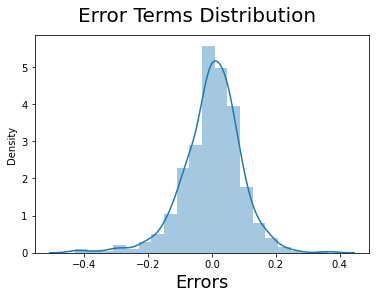

In [62]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms Distribution', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)    
plt.show()

##### <font color=pink>We can see that error terms are normally distributed with mean around zero. </font>
 

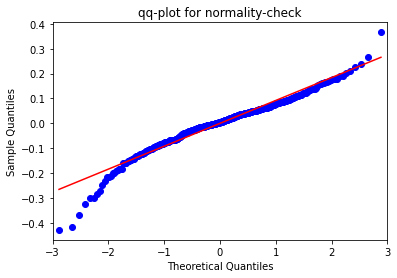

In [63]:
res = lm.resid
sm.qqplot(res,line='s')
plt.title('qq-plot for normality-check')
plt.show()

##### <font color=pink>Q-Q plot also shows that error terms are normally distributed as data points lie on the straight line. </font>

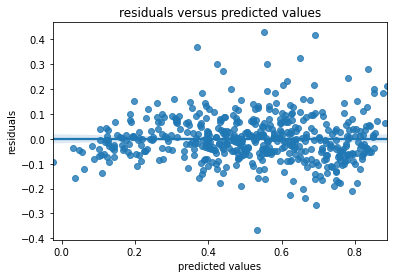

In [64]:
sns.regplot(x=y_train_pred, y=(y_train_pred - y_train))
plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.title('residuals versus predicted values')
plt.show()

##### <font color=pink>From above we can see that error terms are independent of each other as we dont see any pattern . </font>

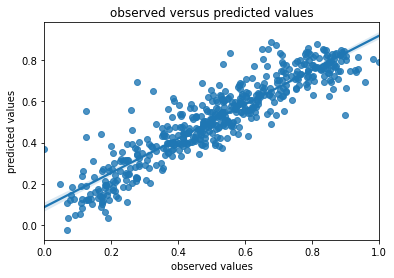

In [65]:
sns.regplot(x=y_train, y=y_train_pred)
plt.xlabel('observed values')
plt.ylabel('predicted values')
plt.title('observed versus predicted values')
plt.show()

##### <font color=pink>From above we can see that error terms have approximately constant variance . </font>

### <font color=orange>Making Predictions on test set: </font>

In [66]:
# Imputing with median if any impossible value present.
df_test['hum']= np.where(df_test['hum'] == 0, hum_med,df_test['hum'])

#### <font color=orange>Applying the scaling on the test sets </font>

In [67]:
num_vars = ['temp','hum','windspeed','date','cnt']
df_test[num_vars]=scaler.transform(df_test[num_vars])  #scaling/transforming test data.

#### <font color=orange>Dividing into X_test and y_test </font>

In [68]:
y_test = df_test.pop('cnt')           #Extracting target variable
X_test = df_test                      #Extracting predictors

In [69]:
# Now let's use our model to make predictions.
X_test_new = X_test[X_train_new.columns]  # Creating X_test_new dataframe by dropping variables from X_test
X_test_new = sm.add_constant(X_test_new)  # Adding a constant term

In [70]:
y_test_pred = lm.predict(X_test_new)  # Making predictions

### <font color=orange>Model Evaluation </font>

Text(0, 0.5, 'y_test_pred')

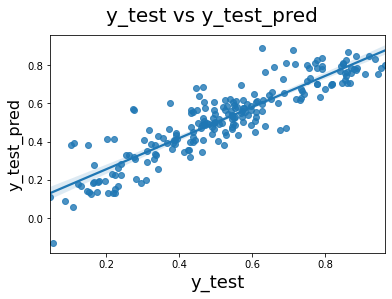

In [71]:
fig = plt.figure()
sns.regplot(x=y_test, y=y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)         # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)

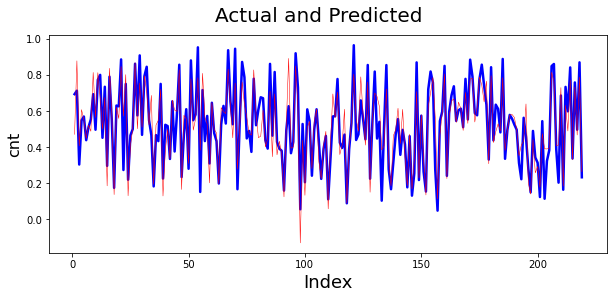

In [72]:
c = [i for i in range(1,220,1)]
fig = plt.figure(figsize=[10,4])
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_test_pred, color="red",  linewidth=0.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('cnt', fontsize=16)
plt.show()

#### calculating MSE and rsquared value for test data:

In [73]:
from sklearn.metrics import mean_squared_error, r2_score 
mse = mean_squared_error(y_test, y_test_pred) 
r_squared = r2_score(y_test, y_test_pred) 
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.009072879079476081
r_square_value : 0.8089751615391357


* R squared value for test data is 80.89% and R squared value for train data was 83.2%. Since both the values lie within 5% range from each other, we will accept the model and can say that we have model with good predictive power.
* MSE is found to be very low which is a good thing

In [74]:
lm.params.sort_values(ascending=False)  # Sorting according to polarity of beta coefficients:

temp                          0.449997
const                         0.258104
yr                            0.235098
mnth_Sep                      0.051903
season_winter                 0.045142
weekday_Sun                  -0.044750
mnth_Jul                     -0.070023
weathersit_Mist              -0.080136
season_spring                -0.114455
windspeed                    -0.140940
weathersit_Light rain/snow   -0.286574
dtype: float64

* Predictors having +ve beta coeff.(slopes): temprature, year, september, winter 
* Predictors having -ve beta coeff.(slopes): sunday, july, mist, spring, windspeed, Light rain/snow 
* y intercept = 0.258104 

In [75]:
abs(lm.params[1:]).sort_values(ascending=False) # Sorting according to WEIGHTAGE of beta coefficients:

temp                          0.449997
weathersit_Light rain/snow    0.286574
yr                            0.235098
windspeed                     0.140940
season_spring                 0.114455
weathersit_Mist               0.080136
mnth_Jul                      0.070023
mnth_Sep                      0.051903
season_winter                 0.045142
weekday_Sun                   0.044750
dtype: float64

## Derived MLR equation:
##### <font color=pink>$ count = 0.2581 + 0.2351 \times (year) + 0.4500 \times (temprature) - 0.1409 \times (windspeed) - 0.1145 \times (spring) + 0.0451 \times (winter) - 0.0700 \times (july) + 0.0519 \times (september) - 0.0447 \times (sunday) - 0.2866 \times (Light Rain/Snow) - 0.0801 \times (mist) $</font>

* for positive beta coefiicient, unit increase in independet variable causes increase in dependent variable (count) by amount of corresponding beta coefiicient, provided that all other independent variables are kept constant. eg. unit increase in temprature will increase count variable by 0.45 if all other predictors are kept constant.
* for negative beta coefiicient, unit increase in independet variable causes decrease in dependent variable (count) by amount of corresponding beta coefiicient, provided that all other independent variables are kept constant. eg. unit increase in windspeed will decrease count variable by 0.141 if all other predictors are kept constant.

## Inference from derived linear equation:
* temprature, light rain/snowy weather and year are top 3 significant predictors.
* As the wind speed increases, demand decrease.
* As the temprature increases, demand will increase.
* During spring season bike demand decreases whereas demand increases in winter season.
* In month july, demand decreases whereas in september demand increases.
* on sunday, demand decreases.

In [76]:
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.009072879079476081
r_square_value : 0.8089751615391357
